# scVI bm CITEseq







## Single study normalization

In [1]:
import tempfile
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import muon
import scanpy as sc
import scvi
import seaborn as sns
import torch
import numpy as np
import time
from scipy.stats import pearsonr
import plotnine as p9

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ADT_data = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/ADT.h5ad')
RNA_data = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/RNA.h5ad')

In [3]:
print(ADT_data)

AnnData object with n_obs × n_vars = 30672 × 25
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize'
    uns: 'X_name'


In [4]:
RNA_data.layers["counts"] = RNA_data.X.copy()
print(RNA_data)

AnnData object with n_obs × n_vars = 30672 × 17009
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize'
    uns: 'X_name'
    layers: 'counts'


#### Now we create a mudata object with muon. This is the equivalent of MultiAssayExperiment or Seurat obj in R, where multiple omics can be stored in one object.

In [5]:
mdata = muon.MuData({'rna': RNA_data, 'adt': ADT_data})

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [6]:
print(mdata)

MuData object with n_obs × n_vars = 30672 × 17034
  2 modalities
    rna:	30672 x 17009
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize'
      uns:	'X_name'
      layers:	'counts'
    adt:	30672 x 25
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize'
      uns:	'X_name'


In [7]:
scvi.settings.seed = 0

[rank: 0] Global seed set to 0


In [8]:
## Use scanpy to filter highly variable genes

sc.pp.highly_variable_genes(
    adata = mdata.mod['rna'],
    layer = 'counts', 
    n_top_genes = 4000,
    flavor = 'seurat_v3',
    batch_key= 'donor')

# Save filtered transcriptome as extra dimension
mdata.mod['filtered_transcriptome'] = mdata.mod['rna'][:, mdata.mod['rna'].var['highly_variable']].copy()
mdata.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [9]:
mdata.mod['rna'].var['highly_variable']

FO538757.2       False
AP006222.2       False
RP4-669L17.10    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AP000223.42      False
DSCR9             True
AP001626.2       False
AP001046.5       False
AC004556.1       False
Name: highly_variable, Length: 17009, dtype: bool

In [10]:
mdata.mod['adt'].X = mdata.mod['adt'].X.toarray()
# Convert to RNA csr matrix for faster training
mdata.mod['rna'].X = mdata.mod['rna'].X.tocsr()
mdata.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [11]:
scvi.model.TOTALVI.setup_mudata(mdata = mdata, 
                                rna_layer = 'counts', 
                                protein_layer= None, 
                                batch_key= 'donor' , 
                                modalities= {"rna_layer":'filtered_transcriptome',
                                             'protein_layer':'adt',
                                             'batch_key':'rna'})

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.


In [12]:
model = scvi.model.TOTALVI(mdata, latent_distribution= 'normal')

INFO     Computing empirical prior initialization for protein background.                                          


In [13]:
start_time = time.time()
model.train()
end_time = time.time()
training_duration = end_time - start_time
mdata.uns['runtime'] = training_duration

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 261/261: 100%|██████████| 261/261 [30:49<00:00,  7.14s/it, v_num=1, train_loss_step=902, train_loss_epoch=882]

`Trainer.fit` stopped: `max_epochs=261` reached.


Epoch 261/261: 100%|██████████| 261/261 [30:49<00:00,  7.09s/it, v_num=1, train_loss_step=902, train_loss_epoch=882]


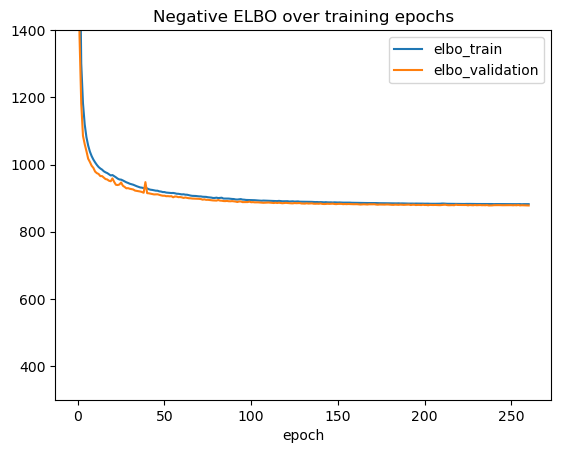

In [15]:
fig, ax = plt.subplots(1, 1)
model.history["elbo_train"].plot(ax=ax, label="train")
model.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs", ylim=(300, 1400))
ax.legend()

In [26]:
# get totalVI's latent dimensions 
mdata.mod['filtered_transcriptome'].obsm['totalVI_latent_dims'] = model.get_latent_representation()
rna_normalized, protein_normalized = model.get_normalized_expression()
mdata.mod['adt'].layers['adt_normalized'] = protein_normalized
mdata.mod['filtered_transcriptome'].layers['rna_normalized'] = rna_normalized
mdata.mod['filtered_transcriptome'].uns['totalVI_runtime'] = training_duration
mdata.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [27]:
# Check if anything looks off
mdata

MuData object with n_obs × n_vars = 30672 × 21034
  obs:	'_scvi_labels', 'runtime'
  uns:	'_scvi_uuid', '_scvi_manager_uuid', 'runtime'
  3 modalities
    rna:	30672 x 17009
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize', '_scvi_batch'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'X_name', 'hvg'
      layers:	'counts'
    adt:	30672 x 25
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize', '_scvi_batch'
      uns:	'X_name'
      layers:	'adt_normalized'
    filtered_transcriptome:	30672 x 4000
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'X_name', 'hvg', 'totalVI_runtime'
      obsm:	'totalVI_latent_dims'
      layers:	'counts', 'rna_normalized'

In [28]:
# Save the muon object as h5 so we can load it into R
#mdata.write_h5mu('/vast/scratch/users/liu.ne/totalVI_mudata')
mdata.mod['adt'].write_h5ad('/vast/scratch/users/liu.ne/totalVI_adt.h5ad')
mdata.mod['filtered_transcriptome'].write_h5ad('/vast/scratch/users/liu.ne/totalVI_rna.h5ad')

## Multi study normalization

In [6]:
# Load the data
merged_ADT = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/merged_ADT.h5ad')
merged_RNA = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/merged_RNA.h5ad')

In [7]:
merged_data = muon.MuData({'RNA': merged_RNA, 'ADT': merged_ADT})

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [24]:
# Somehow some CD receptors are also in RNA????
(merged_ADT.var_names).intersection(merged_RNA.var_names)

Index(['CD14', 'CD19', 'CD27', 'CD28', 'CD38', 'CD4', 'CD69'], dtype='object')